C:\Users\swara\AppData\Local\Temp\ipykernel_10336\3640985493.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


Parametric VaR & CVaR:
  Confidence Level         VaR        CVaR
0           90.00%  ₹11,985.56  ₹16,629.29
1           95.00%  ₹15,549.06  ₹19,647.70
2           99.00%  ₹22,233.61  ₹25,557.43

VaR Breach Analysis:
90% VaR: 124 breaches (10.02% of days)
95% VaR: 62 breaches (5.01% of days)
99% VaR: 13 breaches (1.05% of days)


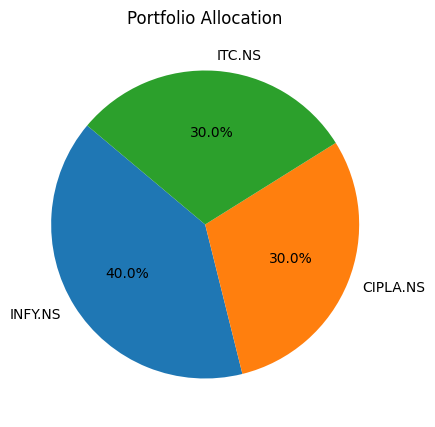

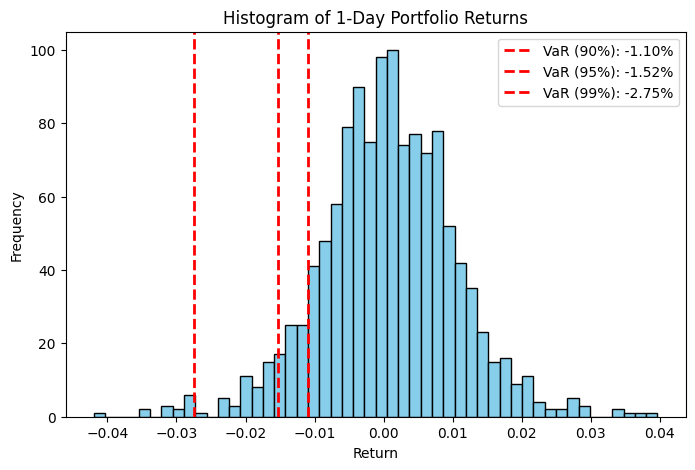

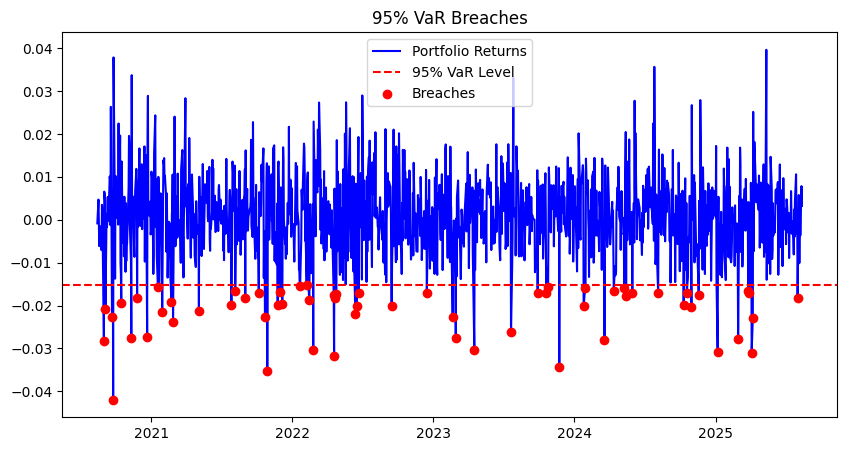

In [2]:
# ==========================
# Parametric VaR Model
# ==========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import norm
import yfinance as yf

# ------------------- CONFIGURATION -------------------
YEARS = 5
TICKERS = ['INFY.NS', 'CIPLA.NS', 'ITC.NS']
WEIGHTS = [0.4, 0.3, 0.3]  # Customizable portfolio weights
PORTFOLIO_VALUE = 1_000_000
CONFIDENCE_LEVELS = [0.90, 0.95, 0.99]
DAYS = 1
PLOT_RESULTS = True
# ------------------------------------------------------

def fetch_price_data(tickers, years):
    """Fetch adjusted closing prices for given tickers over the past `years`."""
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days=years * 365)
    prices = yf.download(tickers, start=start_date, end=end_date)['Close']
    return prices.ffill().dropna()

def calculate_log_returns(prices):
    """Calculate daily log returns."""
    return np.log(prices / prices.shift(1)).dropna()

def calculate_portfolio_returns(log_returns, weights):
    """Calculate portfolio returns from log returns and weights."""
    weights = np.array(weights)
    weights = weights / np.sum(weights)  # normalize
    return log_returns.dot(weights)

def calculate_portfolio_volatility(log_returns, weights):
    """Calculate portfolio volatility using covariance matrix."""
    weights = np.array(weights)  # convert to NumPy array
    cov_matrix = log_returns.cov()
    return np.sqrt(weights.T @ cov_matrix @ weights)

def calculate_parametric_var_cvar(portfolio_mean, portfolio_std, portfolio_value, confidence_levels):
    """Calculate parametric VaR & CVaR."""
    results = []
    for cl in confidence_levels:
        z_score = norm.ppf(1 - cl)
        var = abs(portfolio_value * (portfolio_mean + z_score * portfolio_std))
        cvar = abs(portfolio_value * (portfolio_mean - (norm.pdf(z_score) / (1 - cl)) * portfolio_std))
        results.append({
            "Confidence Level": f"{cl*100:.2f}%",
            "VaR": f"₹{var:,.2f}",
            "CVaR": f"₹{cvar:,.2f}"
        })
    return pd.DataFrame(results)

def backtest_var_breaches(range_returns, cl):
    """Count breaches where actual return < VaR cutoff."""
    var_cutoff = np.percentile(range_returns, (1 - cl) * 100)
    breaches = range_returns < var_cutoff
    return breaches.sum(), breaches.mean()

def plot_portfolio_weights(tickers, weights):
    """Plot portfolio allocation."""
    plt.figure(figsize=(5, 5))
    plt.pie(weights, labels=tickers, autopct='%1.1f%%', startangle=140)
    plt.title("Portfolio Allocation")
    plt.show()

def plot_distribution(range_returns, confidence_levels, days):
    """Plot distribution with VaR cutoffs."""
    plt.figure(figsize=(8, 5))
    plt.hist(range_returns, bins=50, color='skyblue', edgecolor='black')
    for cl in confidence_levels:
        cutoff = np.percentile(range_returns, (1 - cl) * 100)
        plt.axvline(cutoff, color='red', linestyle='dashed', linewidth=2,
                    label=f'VaR ({int(cl * 100)}%): {cutoff:.2%}')
    plt.title(f'Histogram of {days}-Day Portfolio Returns')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def plot_var_breaches(portfolio_returns, cl, days):
    """Plot time series with VaR breaches."""
    range_returns = portfolio_returns.rolling(window=days).sum().dropna()
    var_cutoff = np.percentile(range_returns, (1 - cl) * 100)
    breaches = range_returns < var_cutoff

    plt.figure(figsize=(10, 5))
    plt.plot(range_returns.index, range_returns, label="Portfolio Returns", color="blue")
    plt.axhline(var_cutoff, color="red", linestyle="--", label=f"{int(cl*100)}% VaR Level")
    plt.scatter(range_returns.index[breaches], range_returns[breaches], color="red", label="Breaches", zorder=5)
    plt.title(f"{int(cl*100)}% VaR Breaches")
    plt.legend()
    plt.show()

# ------------------- MAIN SCRIPT -------------------
if __name__ == "__main__":
    prices = fetch_price_data(TICKERS, YEARS)
    log_returns = calculate_log_returns(prices)
    portfolio_returns = calculate_portfolio_returns(log_returns, WEIGHTS)
    portfolio_std_dev = calculate_portfolio_volatility(log_returns, WEIGHTS)
    portfolio_mean = portfolio_returns.mean()

    # Calculate VaR & CVaR
    var_cvar_df = calculate_parametric_var_cvar(portfolio_mean, portfolio_std_dev, PORTFOLIO_VALUE, CONFIDENCE_LEVELS)
    print("\nParametric VaR & CVaR:")
    print(var_cvar_df)

    # Backtesting
    print("\nVaR Breach Analysis:")
    range_returns = portfolio_returns.rolling(window=DAYS).sum().dropna()
    for cl in CONFIDENCE_LEVELS:
        breaches, breach_rate = backtest_var_breaches(range_returns, cl)
        print(f"{int(cl*100)}% VaR: {breaches} breaches ({breach_rate:.2%} of days)")

    # Plots
    if PLOT_RESULTS:
        plot_portfolio_weights(TICKERS, WEIGHTS)
        plot_distribution(range_returns, CONFIDENCE_LEVELS, DAYS)
        plot_var_breaches(portfolio_returns, 0.95, DAYS)
